In [24]:
import json
import math

from wavNN.train_model import TrainingLoop
from wavNN.models.wavMLP import WavMLP
from wavNN.models.vanillaMLP import VanillaMLP, BananaSplitMLP
from wavNN.models.wavpool import WavPool
from wavNN.data_generators.mnist_generator import *

import torch

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
def select_params(
    hidden_size,
    loss_id,
    level,
    optimizer_class_id,
    optimizer_lr,
    optimizer_momentum_id,
    ):

    optimizer_class = (
        torch.optim.SGD if optimizer_class_id < 0.5 else torch.optim.Adam
    )
    loss = torch.nn.CrossEntropyLoss if loss_id < 0.5 else torch.nn.MultiMarginLoss

    optimizer_config = {"lr": optimizer_lr}
    if optimizer_class == torch.optim.SGD:
        optimizer_config["momentum"] = optimizer_momentum_id < 0.5

    model_params = {
        "in_channels": 28,
        "hidden_size": math.ceil(hidden_size),
        "level": math.ceil(level),
        "out_channels": 10,
    }
    return {
        "opt":optimizer_class, 
        "opt_config":optimizer_config, 
        "loss":loss, 
        "model_params":model_params
    }

In [27]:
def plot_experiment_history(history, history_name): 

    train_loss = torch.tensor([history[i]['train_loss'] for i in history]).detach().numpy()
    train_loss_std = np.std(train_loss, axis=0)
    train_loss_mean = np.mean(train_loss, axis=0)

    val_loss = torch.tensor([history[i]['val_loss'] for i in history]).detach().numpy()
    val_std = np.std(val_loss, axis=0)
    val_mean = np.mean(val_loss, axis=0)

    plt.errorbar(range(len(train_loss_mean)), train_loss_mean, yerr=train_loss_std, label="Train", alpha=.5)
    plt.errorbar(range(len(train_loss_mean)), val_mean, yerr=val_std, label="Validation", alpha=.5)

    plt.title(history_name)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

    train_ac = torch.tensor([history[i]['train_accuracy'] for i in history]).detach().numpy()
    train_ac_std = np.std(train_ac, axis=0)
    train_ac_mean = np.mean(train_ac, axis=0)

    val_ac = torch.tensor([history[i]['val_accuracy'] for i in history]).detach().numpy()
    val_std = np.std(val_ac, axis=0)
    val_mean = np.mean(val_ac, axis=0)

    plt.errorbar(range(len(train_ac_mean)), train_ac_mean, yerr=train_ac_std, label="Train", alpha=.5)
    plt.errorbar(range(len(train_ac_mean)), val_mean, yerr=val_std, label="Validation", alpha=.5)

    plt.legend()
    plt.title(history_name)
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.show()

In [3]:
# Open the params and do the variance test
with open("../results/optimization/vanilla_baysianopt.json", 'r') as f: 
    vanilla_params = json.load(f)

vanilla_params_guass = pd.DataFrame(vanilla_params).iloc[pd.DataFrame(vanilla_params)['target'].idxmax()]['params']

vanilla_params = select_params(
    hidden_size=vanilla_params_guass['hidden_size'], 
    loss_id=vanilla_params_guass['loss_id'], 
    level=0, 
    optimizer_class_id=vanilla_params_guass['optimizer_class_id'], 
    optimizer_lr=vanilla_params_guass['optimizer_lr'], 
    optimizer_momentum_id=vanilla_params_guass['optimizer_momentum_id']
)
print(vanilla_params)

{'opt': <class 'torch.optim.sgd.SGD'>, 'opt_config': {'lr': 0.03637816735909994, 'momentum': False}, 'loss': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'model_params': {'in_channels': 28, 'hidden_size': 73, 'level': 0, 'out_channels': 10}}


In [18]:
all_vanilla_history = {}
num_tests = 10

data_params = {"sample_size": [4000, 2000, 2000], "split": True}
vanilla_params['model_params'].pop("level")

for iteration in range(num_tests): 

    training = TrainingLoop(
        model_class=VanillaMLP,
        model_params=vanilla_params["model_params"],
        data_class=NMISTGenerator,
        data_params=data_params,
        optimizer_class=vanilla_params['opt'],
        optimizer_config=vanilla_params['opt_config'],
        loss=vanilla_params['loss'],
        epochs=80,
    )

    training()
    all_vanilla_history[iteration] = training.history

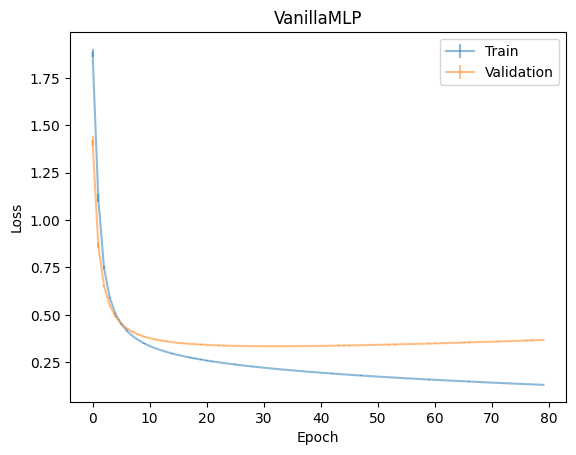

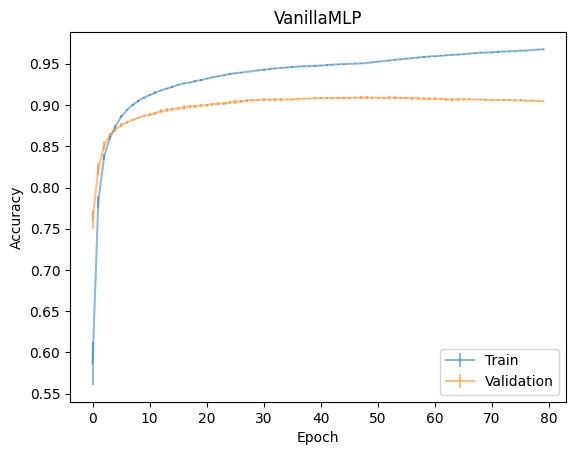

In [33]:
plot_experiment_history(all_vanilla_history, "VanillaMLP")

In [5]:
with open("../results/optimization/wavmlp_baysianopt.json", 'r') as f: 
    wav_params = json.load(f)

wav_params_guass = pd.DataFrame(wav_params).iloc[pd.DataFrame(wav_params)['target'].idxmax()]['params']

wav_params = select_params(
    hidden_size=wav_params_guass['hidden_size'], 
    loss_id=wav_params_guass['loss_id'], 
    level=wav_params_guass['level'], 
    optimizer_class_id=wav_params_guass['optimizer_class_id'], 
    optimizer_lr=wav_params_guass['optimizer_lr'], 
    optimizer_momentum_id=wav_params_guass['optimizer_momentum_id']
)
print(wav_params)

{'opt': <class 'torch.optim.sgd.SGD'>, 'opt_config': {'lr': 0.016983872126037327, 'momentum': False}, 'loss': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'model_params': {'in_channels': 28, 'hidden_size': 659, 'level': 3, 'out_channels': 10}}


In [34]:
all_wavNN_history = {}
num_tests = 10


data_params = {"sample_size": [4000, 2000, 2000], "split": True}

for iteration in range(num_tests): 

    training = TrainingLoop(
        model_class=WavMLP,
        model_params=wav_params["model_params"],
        data_class=NMISTGenerator,
        data_params=data_params,
        optimizer_class=wav_params['opt'],
        optimizer_config=wav_params['opt_config'],
        loss=wav_params['loss'],
        epochs=80,
    )

    training()
    all_wavNN_history[iteration] = training.history

/Users/maggiev-local/repo/wavNN/wavNN/models/wavelet_layer.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  "pywt": lambda x: torch.Tensor(pywt.wavedec2(x, "db1")[level]),


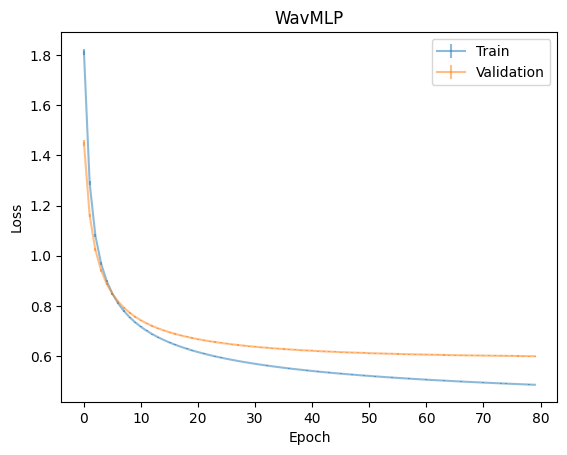

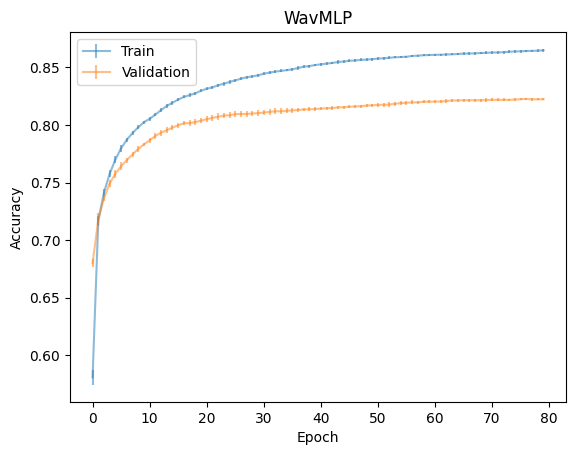

In [35]:
plot_experiment_history(all_wavNN_history, "WavMLP")

In [6]:
# Open the params and do the variance test
with open("../results/optimization/vanilla_split_baysianopt.json", 'r') as f: 
    vanilla_split_params = json.load(f)

vanilla_split_params_guass = pd.DataFrame(vanilla_split_params).iloc[pd.DataFrame(vanilla_split_params)['target'].idxmax()]['params']

vanilla_split_params = select_params(
    hidden_size=vanilla_split_params_guass['hidden_size'], 
    loss_id=vanilla_split_params_guass['loss_id'], 
    level=0, 
    optimizer_class_id=vanilla_split_params_guass['optimizer_class_id'], 
    optimizer_lr=vanilla_split_params_guass['optimizer_lr'], 
    optimizer_momentum_id=vanilla_split_params_guass['optimizer_momentum_id']
)
print(vanilla_split_params)

{'opt': <class 'torch.optim.sgd.SGD'>, 'opt_config': {'lr': 0.05479500771794423, 'momentum': False}, 'loss': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'model_params': {'in_channels': 28, 'hidden_size': 605, 'level': 0, 'out_channels': 10}}


In [5]:
all_vanilla_split_history = {}
num_tests = 10

data_params = {"sample_size": [4000, 2000, 2000], "split": True}
vanilla_split_params['model_params'].pop("level")

for iteration in range(num_tests): 

    training = TrainingLoop(
        model_class=BananaSplitMLP,
        model_params=vanilla_split_params["model_params"],
        data_class=NMISTGenerator,
        data_params=data_params,
        optimizer_class=vanilla_split_params['opt'],
        optimizer_config=vanilla_split_params['opt_config'],
        loss=vanilla_split_params['loss'],
        epochs=80,
    )

    training()
    all_vanilla_split_history[iteration] = training.history

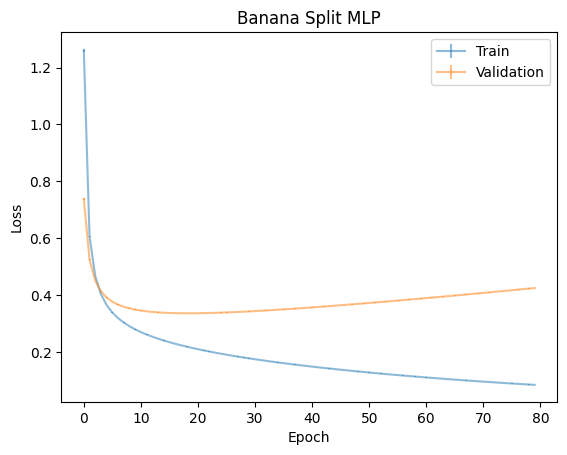

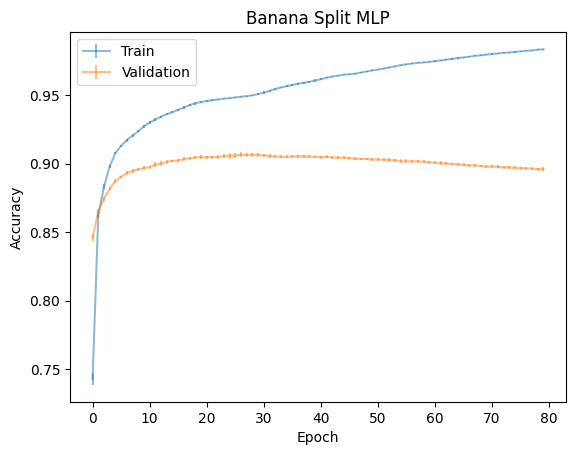

In [6]:
plot_experiment_history(all_vanilla_split_history, "Banana Split MLP")

In [ ]:
# Timing Tests 

# For both the same networks and same parameter'd networks, which are faster. 

In [7]:
# Optized 
import time 
num_tests = 100 

data_params = {"sample_size": [4000, 2000, 2000], "split": True}
vanilla_split_params['model_params'].pop("level")
vanilla_params['model_params'].pop("level")


vanilla_timing = []
banana_timing = []
wav_timing = []

vanilla_network = TrainingLoop(
        model_class=VanillaMLP,
        model_params=vanilla_params["model_params"],
        data_class=NMISTGenerator,
        data_params=data_params,
        optimizer_class=vanilla_params['opt'],
        optimizer_config=vanilla_params['opt_config'],
        loss=vanilla_params['loss'],
        epochs=1,
    )

banana_network = TrainingLoop(
        model_class=BananaSplitMLP,
        model_params=vanilla_split_params["model_params"],
        data_class=NMISTGenerator,
        data_params=data_params,
        optimizer_class=vanilla_split_params['opt'],
        optimizer_config=vanilla_split_params['opt_config'],
        loss=vanilla_split_params['loss'],
        epochs=1,
    )
wav_network = TrainingLoop(
        model_class=WavMLP,
        model_params=wav_params["model_params"],
        data_class=NMISTGenerator,
        data_params=data_params,
        optimizer_class=wav_params['opt'],
        optimizer_config=wav_params['opt_config'],
        loss=wav_params['loss'],
        epochs=1,
    )

for _ in range(num_tests): 

    start = time.time() 
    vanilla_network() 
    vanilla_timing.append(time.time()-start)

    start = time.time() 
    banana_network() 
    banana_timing.append(time.time()-start)

    start = time.time() 
    wav_network() 
    wav_timing.append(time.time()-start)

In [8]:
pd.DataFrame({"vanilla_timing":vanilla_timing, "wav_timing":wav_timing, "banana_timing":banana_timing}).describe()

,vanilla_timing,wav_timing,banana_timing
count,100.000000,100.000000,100.000000
mean,0.254476,0.388343,0.426813
std,0.007865,0.031199,0.022354
min,0.244394,0.368939,0.406782
25%,0.250655,0.377405,0.417516
50%,0.253543,0.382401,0.422703
75%,0.257778,0.389872,0.427324
max,0.316175,0.613781,0.604746


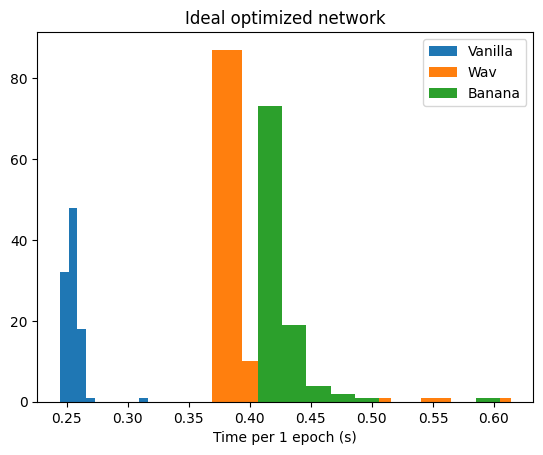

In [9]:
plt.hist(vanilla_timing, label='Vanilla')
plt.hist(wav_timing, label='Wav')
plt.hist(banana_timing, label='Banana')
plt.xlabel("Time per 1 epoch (s)")
plt.title("Ideal optimized network")
plt.legend()
plt.show()

In [10]:
# Parameter numbers 

optimized_vanilla = VanillaMLP(**vanilla_params["model_params"])
total_opt_vanilla_params = sum(p.numel() for p in optimized_vanilla.parameters() if p.requires_grad)

opt_wav = WavMLP(**wav_params['model_params'])
total_opt_wav_params = sum(p.numel() for p in opt_wav.parameters() if p.requires_grad)

opt_banana = BananaSplitMLP(**vanilla_split_params['model_params'])
opt_banana_parameters = sum(p.numel() for p in opt_banana.parameters() if p.requires_grad)

print(f"Optimized Vanilla N Params: {total_opt_vanilla_params}")
print(f"Optimized Wav N Params: {total_opt_wav_params}")
print(f"Optimized Banana split N Params: {opt_banana_parameters}")


Optimized Vanilla N Params: 58045
Optimized Wav N Params: 118630
Optimized Banana split N Params: 1442935


In [11]:
# Non-Optized 
import time 
num_tests = 100 

data_params = {"sample_size": [4000, 2000, 2000], "split": True}

vanilla_timing = []
banana_timing = []
wav_timing = []

vanilla_params = {
            "in_channels": 28,
            "hidden_size": 256,
            "out_channels": 10,
            "tail": True,
        }
banana_params = vanilla_params.copy()
wav_params = vanilla_params.copy()
wav_params["level"] = 3

optimizer_config = {
     "lr": 0.1, 
     "momentum":False
}

vanilla_network = TrainingLoop(
        model_class=VanillaMLP,
        model_params=vanilla_params,
        data_class=NMISTGenerator,
        data_params=data_params,
        loss=torch.nn.CrossEntropyLoss,
        optimizer_class=torch.optim.SGD, 
        optimizer_config=optimizer_config,
        epochs=1,
    )

banana_network = TrainingLoop(
        model_class=BananaSplitMLP,
        model_params=banana_params,
        data_class=NMISTGenerator,
        data_params=data_params,
        loss=torch.nn.CrossEntropyLoss,
        optimizer_class=torch.optim.SGD, 
        optimizer_config=optimizer_config,
        epochs=1,
    )

wav_network = TrainingLoop(
        model_class=WavMLP,
        model_params=wav_params,
        data_class=NMISTGenerator,
        data_params=data_params,
        loss=torch.nn.CrossEntropyLoss,
        optimizer_class=torch.optim.SGD, 
        optimizer_config=optimizer_config,
        epochs=1,
    )

for _ in range(num_tests): 

    start = time.time() 
    vanilla_network() 
    vanilla_timing.append(time.time()-start)

    start = time.time() 
    banana_network() 
    banana_timing.append(time.time()-start)

    start = time.time() 
    wav_network() 
    wav_timing.append(time.time()-start)

In [12]:
pd.DataFrame({"vanilla_timing":vanilla_timing, "wav_timing":wav_timing, "banana_timing":banana_timing}).describe()

,vanilla_timing,wav_timing,banana_timing
count,100.000000,100.000000,100.000000
mean,0.316603,0.384293,0.384358
std,0.030999,0.028156,0.040313
min,0.278739,0.345912,0.327838
25%,0.289345,0.362297,0.348332
50%,0.312438,0.381050,0.382325
75%,0.334180,0.400538,0.406376
max,0.423702,0.464558,0.489143


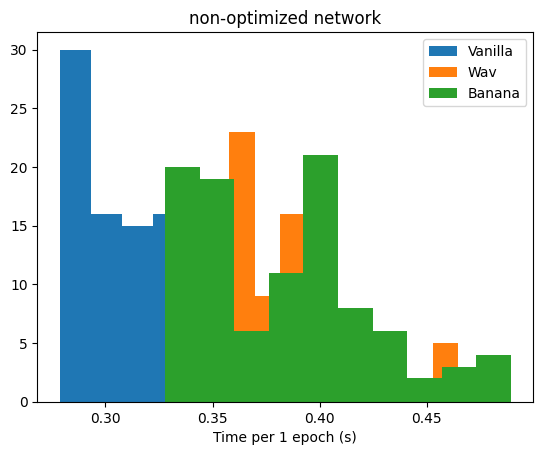

In [13]:
plt.hist(vanilla_timing, label='Vanilla')
plt.hist(wav_timing, label='Wav')
plt.hist(banana_timing, label='Banana')
plt.xlabel("Time per 1 epoch (s)")
plt.title("non-optimized network")
plt.legend()
plt.show()

In [28]:

vanilla_params = {
            "in_channels": 28,
            "hidden_size": 256,
            "out_channels": 10,
            "tail": True,
        }
banana_params = vanilla_params.copy()
wav_params = vanilla_params.copy()
wav_params["level"] = 3


vanilla = VanillaMLP(**vanilla_params)
n_vanilla_params = sum(p.numel() for p in vanilla.parameters() if p.requires_grad)

wav = WavMLP(**wav_params)
n_wav_params = sum(p.numel() for p in wav.parameters() if p.requires_grad)

banana = BananaSplitMLP(**vanilla_split_params['model_params'])
n_banana_parameters = sum(p.numel() for p in banana.parameters() if p.requires_grad)

print(f"Non Optimized Vanilla N Params: {n_vanilla_params}")
print(f"Non Optimized Wav N Params: {n_wav_params}")
print(f"Non Optimized Banana split N Params: {n_banana_parameters}")

Non Optimized Vanilla N Params: 203530
Non Optimized Wav N Params: 46090
Non Optimized Banana split N Params: 1442935


In [18]:
## Highly dependent on init conditions
## Let's check the optimized version
model_params_baysian_path = "../results/optimization/wavpool_baysianopt.json"
with open(model_params_baysian_path, 'r') as f: 
    opt_params = json.load(f) 

wavepool_opt_params = pd.DataFrame(opt_params).iloc[pd.DataFrame(opt_params)['target'].idxmax()]['params']

In [21]:
wavepool_opt_params

{'hidden_pooling_size': 4.0,
 'hidden_size': 423.88668401932256,
 'level_pooling_size': 1.0,
 'loss_id': 0.1154280237730961,
 'optimizer_class_id': 0.8989723475654431,
 'optimizer_lr': 0.0694797027280627,
 'optimizer_momentum_id': 0.49217496086619184,
 'pooling_mode_id': 0.7040360357336669}

In [23]:
def select_wavpool_params(optimizer_class_id, loss_id, optimizer_lr, optimizer_momentum_id, hidden_size, hidden_pooling_size, level_pooling_size, pooling_mode_id):
    optimizer_class = (
                torch.optim.SGD if optimizer_class_id < 0.5 else torch.optim.Adam
            )
    loss = torch.nn.CrossEntropyLoss if loss_id < 0.5 else torch.nn.MultiMarginLoss

    optimizer_config = {"lr": optimizer_lr}
    if optimizer_class == torch.optim.SGD:
        optimizer_config["momentum"] = optimizer_momentum_id < 0.5

    pooling_mode = "average" if pooling_mode_id < 0.5 else "max"

    model_params = {
                "in_channels": 28,
                "hidden_size": math.ceil(hidden_size),
                "hidden_pooling": math.ceil(hidden_size/hidden_pooling_size), 
                "level_pooling": math.ceil(level_pooling_size),
                "out_channels": 10,
                "pooling_mode": pooling_mode
            }
    return optimizer_class, loss, optimizer_config, model_params 

data_params = {"sample_size": [4000, 2000, 2000], "split": True}
optimizer_class, loss, optimizer_config, model_params = select_wavpool_params(**wavepool_opt_params)

In [34]:
model_params

{'in_channels': 28,
 'hidden_size': 424,
 'hidden_pooling': 106,
 'level_pooling': 1,
 'out_channels': 10,
 'pooling_mode': 'max'}

In [28]:
num_tests = 10

data_params = {"sample_size": [4000, 2000, 2000], "split": True}
wavpool_history = {}
for iteration in range(num_tests): 

    training = TrainingLoop(
        model_class=WavPool,
        model_params=model_params,
        data_class=NMISTGenerator,
        data_params=data_params,
        optimizer_class=optimizer_class,
        optimizer_config=optimizer_config,
        loss=loss,
        epochs=80,
    )

    training()
    wavpool_history[iteration] = training.history

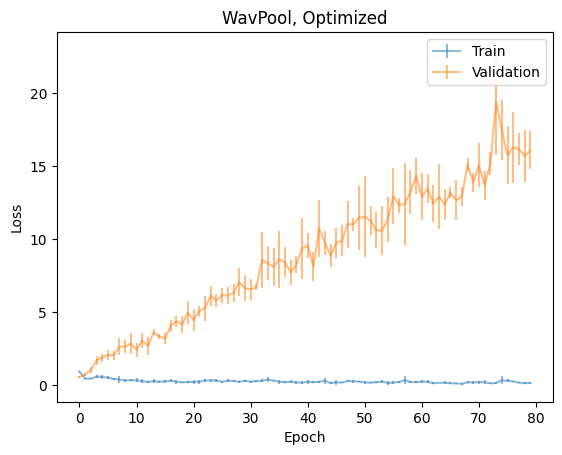

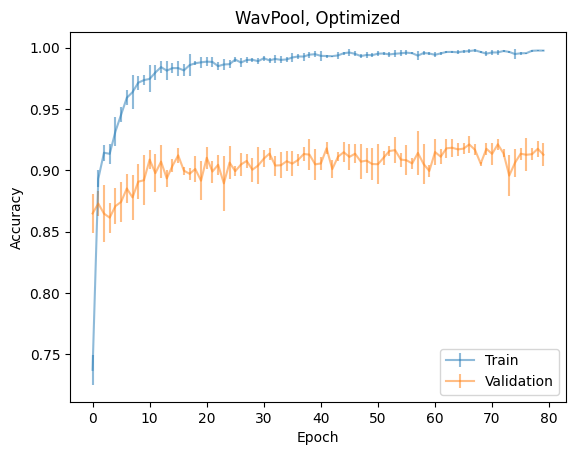

In [30]:
plot_experiment_history(wavpool_history, "WavPool, Optimized")